In [1]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from drug_class_helpers import *

# seeds for reproducibility
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data and extra preprocessing

In [2]:
SEGMENTS_DIR = "preprocessed_data/segments"
FEATURE_COLS = ["X_norm", "Y_norm", "Speed", "turning_angle"]
SEGMENT_LENGTH = 900

dfs = load_and_preprocess(SEGMENTS_DIR)
dfs[0].head()


100%|██████████| 8150/8150 [00:16<00:00, 496.40it/s]


,GlobalFrame,Timestamp,Speed,X,Y,condition,source_file,Segment_index,turning_angle,worm_id,Segment,X_centered,Y_centered,X_rot,Y_rot,X_norm,Y_norm
0,2.0,2024-08-27T15:43:40.009947,-0.424172,0.415679,0.405714,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,0.000000,20240827_piworm10_1,0.0,0.000000,0.000000,0.000000,0.000000e+00,1.117078,-1.123691
1,3.0,2024-08-27T15:43:42.001966,-0.424172,0.416102,0.405726,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,-0.215921,20240827_piworm10_1,0.0,0.000423,0.000013,0.000424,3.761451e-22,1.165344,-1.123691
2,4.0,2024-08-27T15:43:44.002485,-0.495096,0.416319,0.405562,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,-0.200451,20240827_piworm10_1,0.0,0.000640,-0.000152,0.000635,-1.706355e-04,1.189471,-1.135036
3,5.0,2024-08-27T15:43:46.002854,-0.401777,0.416455,0.405110,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,0.198548,20240827_piworm10_1,0.0,0.000776,-0.000603,0.000758,-6.259191e-04,1.203424,-1.165305
4,6.0,2024-08-27T15:43:48.002383,-0.512398,0.416641,0.404967,control,coordinates_highestspeed_20240827_10_1_with_ti...,0.0,-0.173521,20240827_piworm10_1,0.0,0.000962,-0.000746,0.000940,-7.744318e-04,1.224167,-1.175179


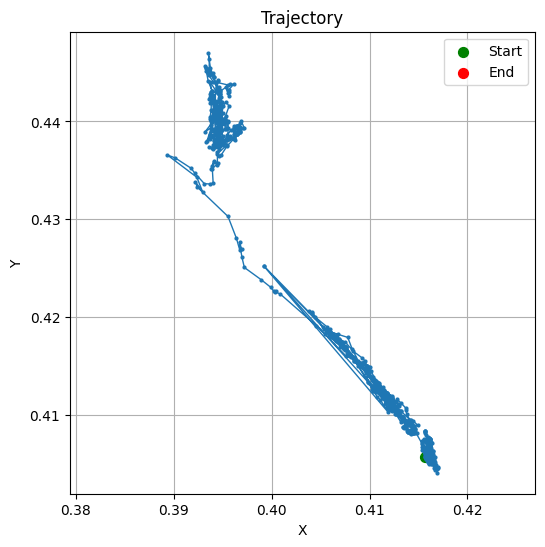

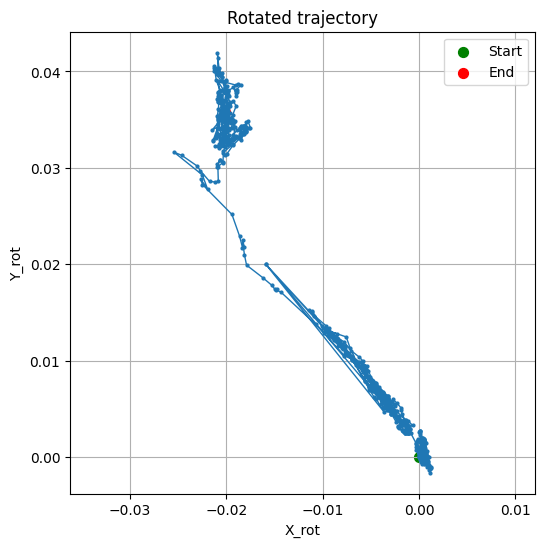

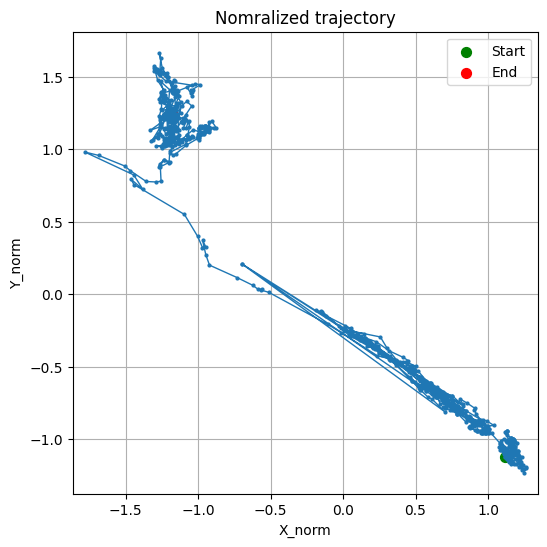

In [33]:
# plot a trajectory
plot_trajectory(dfs[0])
plot_trajectory(dfs[0], "X_rot", "Y_rot", "Rotated trajectory")
plot_trajectory(dfs[0], "X_norm", "Y_norm", "Normalized trajectory")



In [4]:
#prepare preprocessed data for model
X_seg_list = []
y_seg_list = []
worm_ids =[]

for df in dfs:
     # get condition label
    label = df["condition"].iloc[0]
    worm_id = df["worm_id"].iloc[0]

    # extract features
    seg = df[FEATURE_COLS].values

    # handle variable length segments
    if len(seg) < SEGMENT_LENGTH:
        # pad with zeros
        pad_len = SEGMENT_LENGTH - len(seg)
        seg = np.pad(seg, ((0, pad_len), (0, 0)), mode="constant")
    else:
        # truncate
        seg = seg[:SEGMENT_LENGTH]

    X_seg_list.append(seg)
    y_seg_list.append(label)
    worm_ids.append(worm_id)

X_seg = np.array(X_seg_list)   # shape: (n_segments, TIMESTEPS, 4)
y_seg = np.array(y_seg_list)
worm_ids = np.array(worm_ids)

print("X shape:", X_seg.shape)
print("y shape:", y_seg.shape)
print("worm_ids shape:", worm_ids.shape)

X shape: (8150, 900, 4)
y shape: (8150,)
worm_ids shape: (8150,)


In [5]:
# label encoding

le = LabelEncoder()
y_seg_encoded = le.fit_transform(y_seg)

print("Original labels:", np.unique(y_seg))
print("Encoded labels:", np.unique(y_seg_encoded))
print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

#class is balanced ?
(unique, counts) = np.unique(y_seg_encoded, return_counts=True)
print(dict(zip(unique, counts)))

Original labels: ['control' 'terbinafine']
Encoded labels: [0 1]
Mapping: {'control': 0, 'terbinafine': 1}
{0: 4074, 1: 4076}


### worm-level split (no leakage)

In [6]:
#group segments by worm ids to prevent data leakage

unique_worms = np.unique(worm_ids)
print("Total worms:", len(unique_worms))

worm_to_label = {}

# compute one condition label per worm
for w in unique_worms:
    # find any segment for that worm
    idx = np.where(worm_ids == w)[0][0]
    worm_to_label[w] = y_seg_encoded[idx]

worm_labels = np.array([worm_to_label[w] for w in unique_worms])

# stratification 20% test
train_worms, test_worms = train_test_split(
    unique_worms,
    test_size=0.2,
    random_state=0,
    stratify=worm_labels
)

# split again for validation inside model
worm_labels_for_train = np.array([worm_to_label[w] for w in train_worms])

train_worms_final, val_worms = train_test_split(
    train_worms,
    test_size=0.2,
    random_state=0,
    stratify=worm_labels_for_train
)

# build X and y train, validation and test

seg_train_mask = np.isin(worm_ids, train_worms_final)
seg_val_mask = np.isin(worm_ids, val_worms)
seg_test_mask  = np.isin(worm_ids, test_worms)

X_seg_train = X_seg[seg_train_mask]
X_seg_val = X_seg[seg_val_mask]
X_seg_test  = X_seg[seg_test_mask]

y_seg_train = y_seg_encoded[seg_train_mask]
y_seg_val = y_seg_encoded[seg_val_mask]
y_seg_test  = y_seg_encoded[seg_test_mask]

worm_ids_train = worm_ids[seg_train_mask]
worm_ids_val   = worm_ids[seg_val_mask]
worm_ids_test  = worm_ids[seg_test_mask]


print("Train shape:", X_seg_train.shape)
print("Val shape:", X_seg_val.shape)
print("Test shape:",  X_seg_test.shape)

# make sure no worm is in the two sets !!! triple cheeeck

print("Overlap train/val:", np.intersect1d(train_worms_final, val_worms))
print("Overlap train/test:", np.intersect1d(train_worms_final, test_worms))
print("Overlap val/test:", np.intersect1d(val_worms, test_worms))

Total worms: 104
Train shape: (5377, 900, 4)
Val shape: (1272, 900, 4)
Test shape: (1501, 900, 4)
Overlap train/val: []
Overlap train/test: []
Overlap val/test: []


### create smaller windows for the model

In [7]:


X_train_win, y_train_win, worm_train_win = build_overlap_windows(X_seg_train, y_seg_train, worm_ids_train)
X_val_win,   y_val_win,   worm_val_win   = build_overlap_windows(X_seg_val,   y_seg_val,   worm_ids_val)
X_test_win,  y_test_win,  worm_test_win  = build_overlap_windows(X_seg_test,  y_seg_test,  worm_ids_test)


In [8]:
print("Train windows:", X_train_win.shape)
print("Val windows:  ", X_val_win.shape)
print("Test windows: ", X_test_win.shape)

print("Unique worms in train:", len(np.unique(worm_train_win)))
print("Unique worms in test:",  len(np.unique(worm_test_win)))

print("Train segments label counts:", np.bincount(y_seg_train))
print("Val   segments label counts:", np.bincount(y_seg_val))
print("Test  segments label counts:", np.bincount(y_seg_test))

print("Train windows label counts:", np.bincount(y_train_win))
print("Val   windows label counts:", np.bincount(y_val_win))
print("Test  windows label counts:", np.bincount(y_test_win))

Train windows: (26885, 300, 4)
Val windows:   (6360, 300, 4)
Test windows:  (7505, 300, 4)
Unique worms in train: 66
Unique worms in test: 21
Train segments label counts: [2702 2675]
Val   segments label counts: [569 703]
Test  segments label counts: [803 698]
Train windows label counts: [13510 13375]
Val   windows label counts: [2845 3515]
Test  windows label counts: [4015 3490]


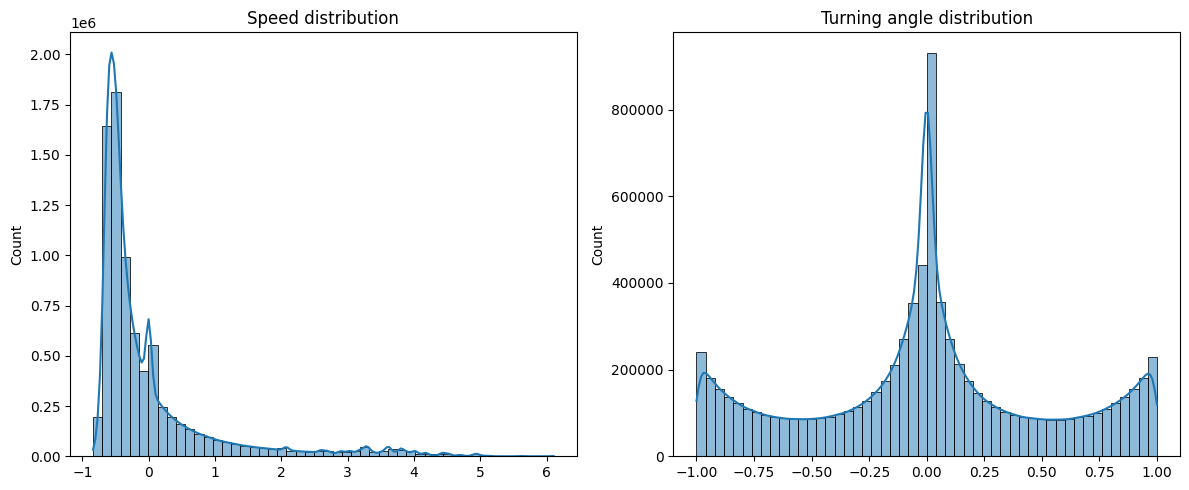

In [9]:
#plot distribution of speed and turning angle in windows


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(X_train_win[:,:,2].flatten(), bins=50, kde=True)
plt.title("Speed distribution")

plt.subplot(1,2,2)
sns.histplot(X_train_win[:,:,3].flatten(), bins=50, kde=True)
plt.title("Turning angle distribution")

plt.tight_layout()
plt.show()


## CNN encoder into Gradient Boosting

In [10]:
#Part 1 : CNN encoder
encoder = build_cnn_encoder()

inp = encoder.input
x = encoder(inp)
x = Dropout(0.1)(x)
out = Dense(1, activation='sigmoid')(x)

cnn_clf = Model(inp, out)
cnn_clf.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy'])

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]


2025-12-15 11:37:35.586930: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-15 11:37:35.587326: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-15 11:37:35.587488: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-15 11:37:35.587675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-15 11:37:35.587698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:

history = cnn_clf.fit(
    X_train_win, y_train_win,
    validation_data=(X_val_win, y_val_win),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100


2025-12-15 11:37:36.676094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


421/421 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.5203 - loss: 0.7338 - val_accuracy: 0.5006 - val_loss: 0.7015
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.5145 - loss: 0.7298 - val_accuracy: 0.5105 - val_loss: 0.6967
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5232 - loss: 0.7164 - val_accuracy: 0.5042 - val_loss: 0.6983
Epoch 4/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5287 - loss: 0.7061 - val_accuracy: 0.4947 - val_loss: 0.6983
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5345 - loss: 0.6967 - val_accuracy: 0.5038 - val_loss: 0.6950
Epoch 6/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5442 - loss: 0.6890 - val_accuracy: 0.5025 - val_loss: 0.6938
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.5501 - loss: 0.6850 - val_accuracy: 0.5142 - val_loss: 0.6946
Epoch 8/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.5521 - loss: 0.6835 - val_

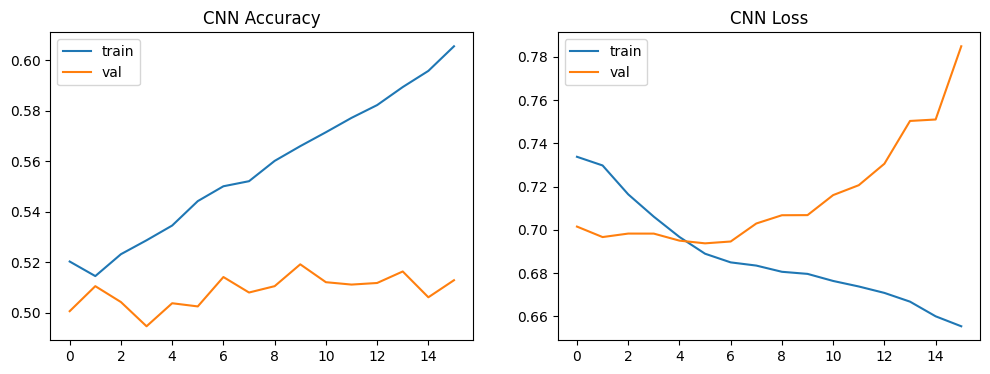

In [12]:
# CNN training curves

plot_training_history(history)


In [13]:
#extract window embeddings
encoder = cnn_clf.get_layer("cnn_encoder")

emb_train = encoder.predict(X_train_win, batch_size=256)
emb_val   = encoder.predict(X_val_win,   batch_size=256)
emb_test  = encoder.predict(X_test_win,  batch_size=256)


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [14]:
# Part 2 : train 2 gradient boosting methods
# Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    max_features=0.9,
    random_state=42
)
gb.fit(emb_train, y_train_win)
win_preds_gb = gb.predict_proba(emb_test)[:, 1]

# CatBoost
cat = CatBoostClassifier(
    iterations=600,
    learning_rate=0.03,
    depth=4,
    loss_function='Logloss',
    verbose=False,
    random_seed=42
)
cat.fit(emb_train, y_train_win, eval_set=(emb_val, y_val_win), verbose=False)
win_preds_cat = cat.predict_proba(emb_test)[:, 1]


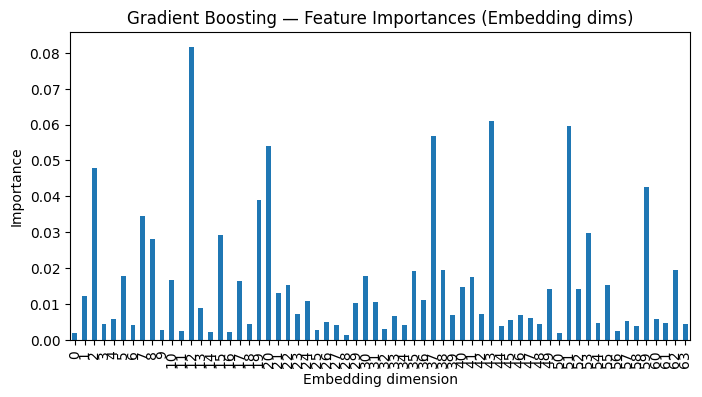

In [15]:
# feature importance plot  (even if the embeddings aren't interpretable for us)

plt.figure(figsize=(8,4))
feat_imp = pd.Series(gb.feature_importances_)
feat_imp.plot(kind="bar")
plt.title("Gradient Boosting — Feature Importances (Embedding dims)")
plt.xlabel("Embedding dimension")
plt.ylabel("Importance")
plt.show()


In [16]:
# worm-level aggregation

worm_gb_softmax = aggregate(worm_test_win, y_test_win, win_preds_gb, method="softmax", T=0.5)
worm_gb_median  = aggregate(worm_test_win, y_test_win, win_preds_gb, method="median")
worm_gb_mean    = aggregate(worm_test_win, y_test_win, win_preds_gb, method="mean")

worm_cat_softmax = aggregate(worm_test_win, y_test_win, win_preds_cat, method="softmax", T=0.5)
worm_cat_median  = aggregate(worm_test_win, y_test_win, win_preds_cat, method="median")
worm_cat_mean    = aggregate(worm_test_win, y_test_win, win_preds_cat, method="mean")


In [17]:

# Gradient Boosting
report(worm_gb_softmax, "GB — Softmax vote")
report(worm_gb_median,  "GB — Median vote")
report(worm_gb_mean,    "GB — Mean vote")

# CatBoost
report(worm_cat_softmax, "CatBoost — Softmax vote")
report(worm_cat_median,  "CatBoost — Median vote")
report(worm_cat_mean,    "CatBoost — Mean vote")



=== GB — Softmax vote ===
Accuracy: 0.47619047619047616
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.46      0.60      0.52        10

    accuracy                           0.48        21
   macro avg       0.48      0.48      0.47        21
weighted avg       0.48      0.48      0.47        21


=== GB — Median vote ===
Accuracy: 0.47619047619047616
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.43      0.30      0.35        10

    accuracy                           0.48        21
   macro avg       0.46      0.47      0.46        21
weighted avg       0.47      0.48      0.46        21


=== GB — Mean vote ===
Accuracy: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.56      0.50      0.53        10

    accuracy    

/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

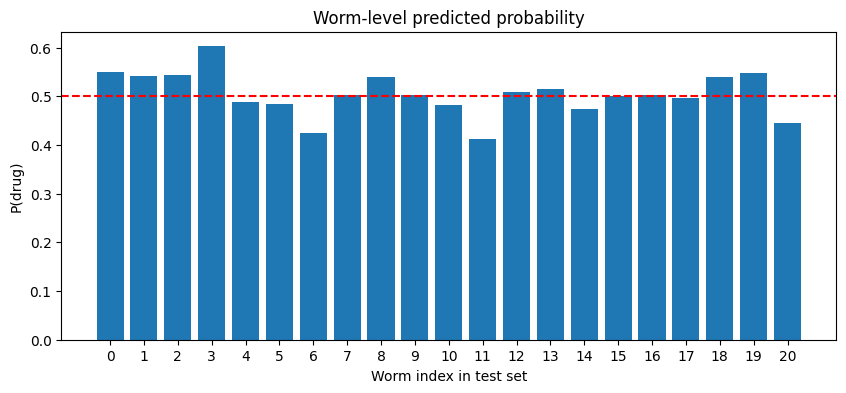

In [32]:
# use one of the six aggregations
worm_df_sorted = worm_gb_softmax.sort_values("worm")

plt.figure(figsize=(10,4))
plt.bar(range(len(worm_df_sorted)), worm_df_sorted["y_pred"])
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Worm-level predicted probability")
plt.xlabel("Worm index in test set")
plt.ylabel("P(drug)")
plt.xticks(range(len(worm_df_sorted)))
plt.show()


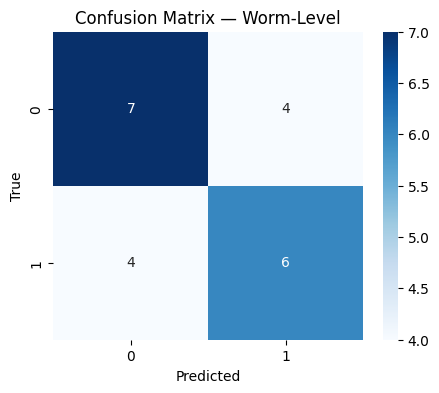

In [19]:
# confusion matrix



cm = confusion_matrix(worm_cat_softmax["y_true"], worm_cat_softmax["y_hat"])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Worm-Level")
plt.show()


## Test on new data

In [20]:
NEW_DIR = "test_data/segments"

new_dfs=load_and_preprocess(NEW_DIR)
new_dfs[0].head()


100%|██████████| 1211/1211 [00:02<00:00, 543.11it/s]


,GlobalFrame,Timestamp,Speed,X,Y,condition,source_file,Segment_index,turning_angle,worm_id,Segment,X_centered,Y_centered,X_rot,Y_rot,X_norm,Y_norm
0,2.0,2025-05-26T14:53:26.008996,1.592214,0.878563,0.725115,control,E.Gencturk_20250526_1453_N2-lifespan-FUDR+Terb...,0.0,0.000000,5,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.116948,-0.373793
1,3.0,2025-05-26T14:53:28.002004,1.592214,0.862680,0.708862,control,E.Gencturk_20250526_1453_N2-lifespan-FUDR+Terb...,0.0,-0.728420,5,0.0,-0.015884,-0.016253,0.022726,1.038967e-18,0.201045,-0.373793
2,4.0,2025-05-26T14:53:30.002476,1.592214,0.861151,0.728098,control,E.Gencturk_20250526_1453_N2-lifespan-FUDR+Terb...,0.0,-0.017543,5,0.0,-0.017412,0.002983,0.010037,-1.453751e-02,0.154090,-0.452985
3,5.0,2025-05-26T14:53:32.002391,1.592214,0.860709,0.746406,control,E.Gencturk_20250526_1453_N2-lifespan-FUDR+Terb...,0.0,0.162768,5,0.0,-0.017855,0.021291,-0.002747,-2.765023e-02,0.106781,-0.524415
4,6.0,2025-05-26T14:53:34.002563,1.592214,0.853203,0.759054,control,E.Gencturk_20250526_1453_N2-lifespan-FUDR+Terb...,0.0,-0.079956,5,0.0,-0.025360,0.033939,-0.006548,-4.185815e-02,0.092717,-0.601811


In [21]:
#prepare preprocessed data for model
X_seg_list = []
y_seg_list = []
worm_ids =[]

for df in new_dfs:
     # get condition label
    label = df["condition"].iloc[0]
    worm_id = df["worm_id"].iloc[0]

    # extract features
    seg = df[FEATURE_COLS].values

    # handle variable length segments
    if len(seg) < SEGMENT_LENGTH:
        # pad with zeros
        pad_len = SEGMENT_LENGTH - len(seg)
        seg = np.pad(seg, ((0, pad_len), (0, 0)), mode="constant")
    else:
        # truncate
        seg = seg[:SEGMENT_LENGTH]

    X_seg_list.append(seg)
    y_seg_list.append(label)
    worm_ids.append(worm_id)

X_new = np.array(X_seg_list)   # shape: (n_segments, TIMESTEPS, 4)
y_new = np.array(y_seg_list)
worm_ids_new = np.array(worm_ids)

print("X shape:", X_new.shape)
print("y shape:", y_new.shape)
print("worm_ids shape:", worm_ids_new.shape)

X shape: (1211, 900, 4)
y shape: (1211,)
worm_ids shape: (1211,)


In [22]:
# label encoding

le = LabelEncoder()
y_new_encoded = le.fit_transform(y_new)

print("Original labels:", np.unique(y_new))
print("Encoded labels:", np.unique(y_new_encoded))
print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

#class is balanced ?
(unique, counts) = np.unique(y_new_encoded, return_counts=True)
print(dict(zip(unique, counts)))

Original labels: ['control' 'terbinafine']
Encoded labels: [0 1]
Mapping: {'control': 0, 'terbinafine': 1}
{0: 621, 1: 590}


In [23]:
X_new_win,  y_new_win,  worm_new_win  = build_overlap_windows(X_new,  y_new_encoded,  worm_ids_new)

In [24]:
print("New windows: ", X_new_win.shape)

print("Unique worms in new data:", len(np.unique(worm_new_win)))

New windows:  (6055, 300, 4)
Unique worms in new data: 19


In [25]:
# apply model in 2 steps
emb_new  = encoder.predict(X_new_win,  batch_size=256)
win_preds_cat_new = cat.predict_proba(emb_new)[:, 1]
win_preds_gb_new = gb.predict_proba(emb_new)[:,1]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [26]:
# aggregation
worm_cat_softmax_new = aggregate(worm_new_win, y_new_win, win_preds_cat_new, method="softmax", T=0.5)
worm_cat_mean_new = aggregate(worm_new_win, y_new_win, win_preds_cat_new, method="mean", T=0.5)
worm_cat_median_new = aggregate(worm_new_win, y_new_win, win_preds_cat_new, method="median", T=0.5)

worm_gb_softmax_new = aggregate(worm_new_win, y_new_win, win_preds_gb_new, method="softmax", T=0.5)
worm_gb_mean_new = aggregate(worm_new_win, y_new_win, win_preds_gb_new, method="mean", T=0.5)
worm_gb_median_new = aggregate(worm_new_win, y_new_win, win_preds_gb_new, method="median", T=0.5)

In [27]:
report(worm_cat_softmax_new, "CatBoost — Softmax vote")
report(worm_cat_mean_new, "CatBoost — mean")
report(worm_cat_median_new, "CatBoost — median")

report(worm_gb_softmax_new, "gb — Softmax vote")
report(worm_gb_mean_new, "gb — mean")
report(worm_gb_median_new, "gb — median")


=== CatBoost — Softmax vote ===
Accuracy: 0.5263157894736842
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19


=== CatBoost — mean ===
Accuracy: 0.5263157894736842
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19


=== CatBoost — median ===
Accuracy: 0.5263157894736842
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accura

/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

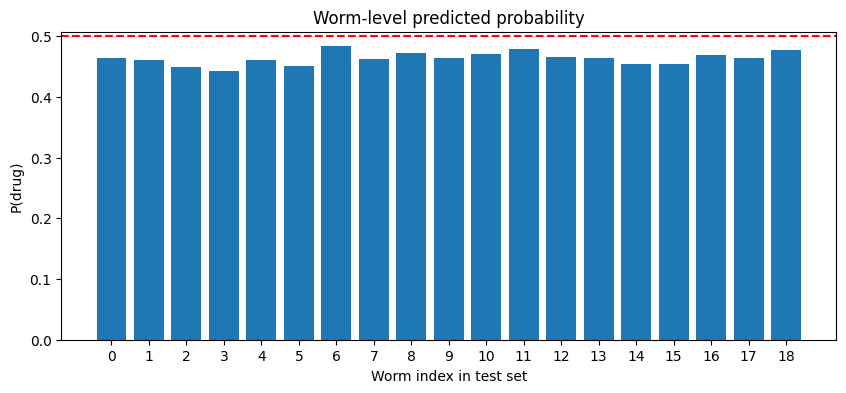

In [31]:
worm_df_sorted = worm_gb_softmax_new.sort_values("worm")

plt.figure(figsize=(10,4))
plt.bar(range(len(worm_df_sorted)), worm_df_sorted["y_pred"])
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Worm-level predicted probability")
plt.xlabel("Worm index in test set")
plt.ylabel("P(drug)")
plt.xticks(range(len(worm_df_sorted)))
plt.show()